In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

from langchain_openai import ChatOpenAI

# LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AnyMessage
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.tools import tool

@tool
def wiki_search(input: str) -> str:
    """Search Wikipedia for a query and return maximum 2 results.
    
    Args:
        input: The search query."""
    search_docs = WikipediaLoader(query=input, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return formatted_search_docs

@tool
def web_search(input: str) -> str:
    """Search the web using Tavily for a query and return maximum 3 results.
    
    Args:
        input: The search query."""
    search_docs = TavilySearchResults(max_results=3).invoke(input)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return formatted_search_docs

tools = [wiki_search, web_search]
llm_with_tools = llm.bind_tools(tools)

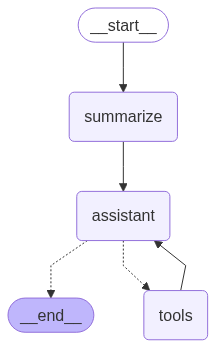

In [3]:
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from datetime import date

today = date.today().strftime("%B %d, %Y")

sys_msg = SystemMessage(content=f"""
You are a helpful assistant tasked with answering questions using a set of tools. You have access to the web and Wikipedia to find more information.
You can also use your own knowledge to answer questions.

Today's date is {today}. Use this for context when needed.

Never assume anything. If you do not know the answer, say you do not know.
Never provide false information or a baseless answer.
Mantain a polite and friendly tone throughout the conversation.
If you used information from online sources, mention it.
"""
)

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    summary: str

# Node
def assistant(state: State):
    """Assistant node"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

def summarize_conversation(state: State):
    """
    Summarizes the conversation so far and updates the state with a new summary.
    """
    messages = state["messages"]

    # Only summarize if there are more than 6 messages (3 user-assistant turns)
    if len(messages) > 6:
    
        # get any existing summary
        summary = state.get("summary", "")
        if summary:
            summary_message = (
                f"This is summary of the conversation to date: {summary}\n\n"
                "Extend or update the summary with the new messages above:"
            )
            
        else:
            summary_message = "Create a summary of the conversation above:"

        # Add prompt to our history
        summary_prompt = messages + [HumanMessage(content=summary_message)]
        response = llm.invoke(summary_prompt)
        
        # Keep last 2 messages plus a summary message
        new_messages = [SystemMessage(content=f"Conversation summary:\n{response.content}")] + [RemoveMessage(id=m.id) for m in messages[:-2]]
    
        return {"summary": response.content, "messages": new_messages}

# Build graph
builder = StateGraph(MessagesState)

# nodes
builder.add_node("summarize", summarize_conversation)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

#  edges
builder.add_edge(START, "summarize")
builder.add_edge("summarize", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": "1"}}
question = "Can you access youtube?"
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is tomorrow's date?
================================== Ai Message ==================================

Tomorrow's date is May 30, 2025.
================================ Human Message =================================

Can you access youtube?
================================== Ai Message ==================================

No, I cannot access YouTube. However, I can help answer questions or find information using the web and Wikipedia. Let me know if there's anything specific you need help with!
